<a href="https://colab.research.google.com/github/yashv04/Match-Simulator-Opponent-Strategy-AI/blob/main/Match_Simulator_%2B_Opponent_AI_Strategy_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implement ball-by-ball match simulator (Markov Chains).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import warnings
warnings.filterwarnings('ignore')

In [ ]:
deliveries = pd.read_csv('deliveries_updated_mens_ipl.csv')
matches = pd.read_csv('matches_updated_mens_ipl.csv')

In [ ]:
df = deliveries.copy()
df = df.rename(columns = {'matchId' : 'match_id', 'batsman_runs' : 'runs_off_bat', 'dismissal_kind': 'wicket_type'})

In [ ]:
# Step 1: Feature Engineering
df['ball_number'] = df['over'] * 6 + df['ball'] - 1
df['is_wicket'] = df['wicket_type'].notnull().astype(int)
df['runs_cumsum'] = df.groupby('match_id')['runs_off_bat'].cumsum()
df['wickets_cumsum'] = df.groupby('match_id')['is_wicket'].cumsum()

In [ ]:
# Step 2: Create next state columns
df['next_runs'] = df['runs_cumsum'].shift(-1)
df['next_wickets'] = df['wickets_cumsum'].shift(-1)
df['next_ball'] = df['ball_number'].shift(-1)
df['next_match_id'] = df['match_id'].shift(-1)
df = df[df['match_id'] == df['next_match_id']]
df.dropna(subset=['next_runs', 'next_wickets', 'next_ball'], inplace=True)

In [ ]:
# Step 3: Build Markov Chain transitions
state_transitions = {}
for _, row in df.iterrows():
    current_state = (int(row['runs_cumsum']), int(row['wickets_cumsum']), int(row['ball_number']))
    next_state = (int(row['next_runs']), int(row['next_wickets']), int(row['next_ball']))
    if current_state not in state_transitions:
        state_transitions[current_state] = []
    state_transitions[current_state].append(next_state)

# Step 4: Convert transitions to probabilities
for state, transitions in state_transitions.items():
    unique_transitions = list(set(transitions))
    probabilities = [transitions.count(t) / len(transitions) for t in unique_transitions]
    state_transitions[state] = (unique_transitions, probabilities)

In [ ]:
# Step 5: Simulation function
def simulate_match(start_state=(0, 0, 0), max_balls=120):
    current_state = start_state
    match_states = [current_state]
    while current_state[2] < max_balls and current_state[1] < 10:
        if current_state in state_transitions:
            next_states, probabilities = state_transitions[current_state]
            current_state = random.choices(next_states, probabilities)[0]
            match_states.append(current_state)
        else:
            break
    return match_states

In [ ]:
simulated_match = simulate_match(start_state=(0, 0, 0))
simulated_df = pd.DataFrame(simulated_match, columns=['Runs', 'Wickets', 'Balls'])

# Output: Last 10 states
print(simulated_df.tail(10))

     Runs  Wickets  Balls
224   213        8     95
225   214        8     96
226   215        8     96
227   215        8     97
228   215        8     98
229   216        8     99
230   216        8    100
231   216        8    101
232   220        8    102
233   221        8    103


#Enhancing the Cricket Match Simulator

In [ ]:
# Modify state transitions to include venue & opponent factors
venue_factors = {'Wankhede': 1.1, 'Chepauk': 0.9, 'Chinnaswamy': 1.2}  # Adjust run probabilities
bowler_types = {'Pace': 1.0, 'Spin': 0.8}  # Reduce runs against spin

In [ ]:
def adjust_probabilities(state, next_states, probabilities, venue, bowler_type):
    # Modify run probabilities based on venue
    venue_factor = venue_factors.get(venue, 1.0)
    bowler_factor = bowler_types.get(bowler_type, 1.0)

    adjusted_probabilities = [
        prob * venue_factor * bowler_factor for prob in probabilities
    ]
    # Normalize to ensure sum = 1
    adjusted_probabilities = np.array(adjusted_probabilities) / sum(adjusted_probabilities)
    return adjusted_probabilities

In [ ]:
def simulate_match_with_factors(start_state=(0, 0, 0), venue='Wankhede', bowler_type='Pace'):
    current_state = start_state
    match_states = [current_state]


    while current_state[2] < 120 and current_state[1] < 10:
        if current_state in state_transitions:
            next_states, probabilities = state_transitions[current_state]
            probabilities = adjust_probabilities(current_state, next_states, probabilities, venue, bowler_type)

            # Ensure next state's ball number doesn't exceed 120 and is unique
            valid_next_states = [state for state in next_states
                                 if state[2] <= 120 and state[2] > current_state[2]]
            if valid_next_states:
                # Adjust probabilities for valid states
                valid_probabilities = [probabilities[next_states.index(state)] for state in valid_next_states]
                # Normalize probabilities
                valid_probabilities = np.array(valid_probabilities) / sum(valid_probabilities)

                current_state = random.choices(valid_next_states, valid_probabilities)[0]
                match_states.append(current_state)
            else:
                break  # No valid next states, end simulation
        else:
            break  # Current state not found in transitions, end simulation

    return match_states

In [ ]:
# Run enhanced simulation
simulated_match = simulate_match_with_factors(venue='Wankhede', bowler_type='Pace')

# Convert to DataFrame for visualization
simulated_df = pd.DataFrame(simulated_match, columns=['Runs', 'Wickets', 'Balls'])

#Visualizing the Simulation Progress

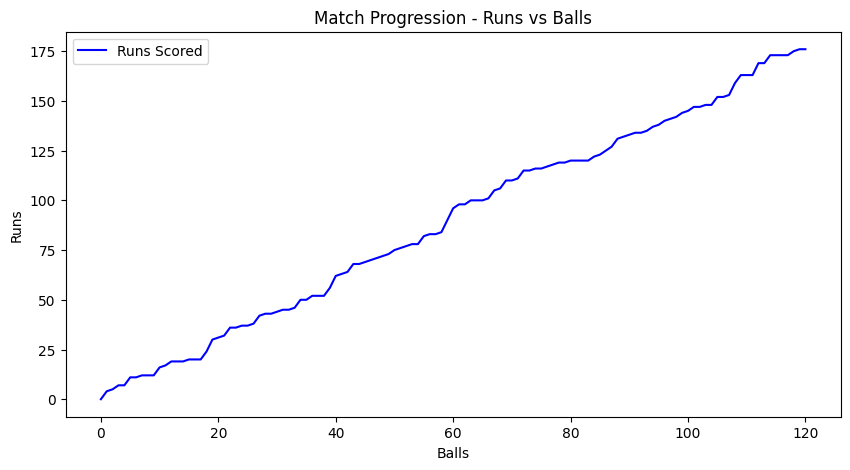

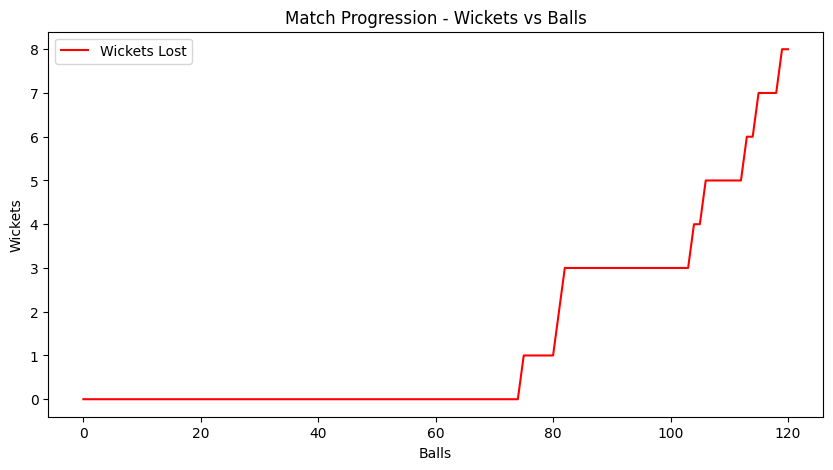

In [ ]:
import matplotlib.pyplot as plt

# Plot Runs Progression
plt.figure(figsize=(10, 5))
plt.plot(simulated_df['Balls'], simulated_df['Runs'], label='Runs Scored', color='blue')
plt.xlabel('Balls')
plt.ylabel('Runs')
plt.title('Match Progression - Runs vs Balls')
plt.legend()
plt.show()

# Plot Wickets Progression
plt.figure(figsize=(10, 5))
plt.plot(simulated_df['Balls'], simulated_df['Wickets'], label='Wickets Lost', color='red')
plt.xlabel('Balls')
plt.ylabel('Wickets')
plt.title('Match Progression - Wickets vs Balls')
plt.legend()
plt.show()

In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.1 MB/s eta 0:00:00


In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

venue_widget = widgets.Dropdown(options=['Wankhede', 'Chepauk', 'Chinnaswamy'], description='Venue:')
bowler_widget = widgets.RadioButtons(options=['Pace', 'Spin'], description='Bowler:')
button = widgets.Button(description="Simulate")

output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output(wait=True)
        match = simulate_match_with_factors(venue=venue_widget.value, bowler_type=bowler_widget.value)
        df = pd.DataFrame(match, columns=["Runs", "Wickets", "Balls"])
        df = df[df['Balls'] <= 120]  # Add this line for filtering
        df.sort_values(by=['Balls'], inplace=True)
        df['Ball Number'] = df.index
           # Plot Runs and Wickets
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Runs vs Balls
        axes[0].plot(df['Balls'], df['Runs'], color='blue')
        axes[0].set_title('Runs vs Balls')
        axes[0].set_xlabel('Balls')
        axes[0].set_ylabel('Runs')

        # Wickets vs Balls
        axes[1].plot(df['Balls'], df['Wickets'], color='red')
        axes[1].set_title('Wickets vs Balls')
        axes[1].set_xlabel('Balls')
        axes[1].set_ylabel('Wickets')

        plt.tight_layout()
        plt.show()

button.on_click(on_button_clicked)

display(venue_widget, bowler_widget, button, output)

Dropdown(description='Venue:', options=('Wankhede', 'Chepauk', 'Chinnaswamy'), value='Wankhede')

RadioButtons(description='Bowler:', options=('Pace', 'Spin'), value='Pace')

Button(description='Simulate', style=ButtonStyle())

Output()

#Add Match Phases: Powerplay, Middle, Death Overs

In [ ]:
def get_phase(ball_number):
    over = ball_number // 6
    if over < 6:
        return 'Powerplay'
    elif over < 16:
        return 'Middle'
    else:
        return 'Death'

phase_factors = {
    'Powerplay': 1.1,
    'Middle': 1.0,
    'Death': 1.3
}

def adjust_probabilities_with_phase(state, next_states, probabilities, venue, bowler_type):
    venue_factor = venue_factors.get(venue, 1.0)
    bowler_factor = bowler_types.get(bowler_type, 1.0)
    phase = get_phase(state[2])
    phase_factor = phase_factors.get(phase, 1.0)

    adjusted_probabilities = [
        prob * venue_factor * bowler_factor * phase_factor for prob in probabilities
    ]
    adjusted_probabilities = np.array(adjusted_probabilities) / sum(adjusted_probabilities)
    return adjusted_probabilities

In [ ]:
#Dynamic Bowling Changes + Strategy AI

def get_bowler_type(over):
    if over < 6 or over > 16:
        return 'Pace'
    else:
        return 'Spin'

In [ ]:
# Display Match Summary
final_state = simulated_df.iloc[-1]
total_runs = final_state['Runs']
total_wickets = final_state['Wickets']
total_overs = final_state['Balls'] // 6 + (final_state['Balls'] % 6) / 10

print(f"Match Summary:")
print(f"Total: {total_runs}/{total_wickets} in {total_overs:.1f} overs")
print(f"Run Rate: {total_runs / (final_state['Balls'] / 6):.2f}")

Match Summary:
Total: 176/8 in 20.0 overs
Run Rate: 8.80


In [ ]:
#Save Results & Visualize
simulated_df.to_csv('simulated_match_output.csv', index=False)

In [ ]:
pip install seaborn plotly

In [ ]:
import plotly.express as px

# Runs Progression
fig_runs = px.line(simulated_df, x='Balls', y='Runs',
                   title='Interactive Runs Progression',
                   labels={'Balls': 'Ball Number', 'Runs': 'Total Runs'},
                   template='plotly_dark')
fig_runs.show()

# Wickets Progression
fig_wickets = px.line(simulated_df, x='Balls', y='Wickets',
                      title='Interactive Wickets Progression',
                      labels={'Balls': 'Ball Number', 'Wickets': 'Total Wickets'},
                      template='plotly_dark')
fig_wickets.show()

#OPPONENT STRATEGY AI

Predict how an opposing team will approach the match — whether they’ll:

1. Use aggressive or conservative batting

2. Open with pace or spin

3. Rotate bowlers in a specific pattern

4. Use specific tactics in different game phases

In [ ]:
matches = pd.read_csv('matches_updated_mens_ipl.csv')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
pip install xgboost imbalanced-learn

In [ ]:
deliveries = pd.read_csv("deliveries_updated_mens_ipl.csv")
matches = pd.read_csv("matches_updated_mens_ipl.csv")

In [ ]:
deliveries['total_runs'] = deliveries.groupby('matchId')['batsman_runs'].cumsum()

Powerplay strategy

In [ ]:
# Merge using matchId
merged_df = deliveries.merge(
    matches[['matchId', 'venue', 'toss_decision', 'team1', 'team2']],
    on='matchId',
    how='left'
)

In [ ]:
powerplay_df = merged_df[merged_df['over'] <= 6]

In [ ]:
# Group by match and batting team to get total runs
powerplay_runs = powerplay_df.groupby(['matchId', 'batting_team'])[['total_runs', 'ball', 'team1', 'venue', 'toss_decision']].agg({'total_runs': 'sum', 'ball': 'count', 'team1': 'first', 'venue': 'first', 'toss_decision': 'first'}).reset_index()

In [ ]:
# Step 2: Feature Engineering – Calculate run rate in powerplay
powerplay_runs['run_rate'] = (powerplay_runs['total_runs'] / powerplay_runs['ball']) * 6

In [ ]:
# Label strategy: Aggressive if RR > 9
powerplay_runs['batting_strategy'] = powerplay_runs['run_rate'].apply(lambda x: 'Aggressive' if x > 9 else 'Conservative')

In [ ]:
# Encode categorical variables
label_encoders = {}

le_team = LabelEncoder()
le_venue = LabelEncoder()
le_toss = LabelEncoder()

powerplay_runs['team1_encoded'] = le_team.fit_transform(powerplay_runs['team1'])
powerplay_runs['venue_encoded'] = le_venue.fit_transform(powerplay_runs['venue'])
powerplay_runs['toss_encoded'] = le_toss.fit_transform(powerplay_runs['toss_decision'])


X = powerplay_runs[['team1_encoded', 'venue_encoded', 'toss_encoded']]
y = powerplay_runs['batting_strategy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", model.score(X_test, y_test))

Model Accuracy: 1.0


Predict Opponent Strategy for a New Match

In [ ]:
# Define a new match context
new_match = {
    'team1': 'Royal Challengers Bangalore',
    'team2': 'Chennai Super Kings',
    'venue': 'M Chinnaswamy Stadium',
    'toss_decision': 'bat',

}

In [ ]:
encoded_input = [
    le_team.transform([new_match['team1']])[0],
    le_venue.transform([new_match['venue']])[0],
    le_toss.transform([new_match['toss_decision']])[0],
]

In [ ]:
# Predict strategy
predicted_strategy = model.predict([encoded_input])[0]
print(f"Predicted Opponent Powerplay Strategy: {predicted_strategy}")

Predicted Opponent Powerplay Strategy: Aggressive


Middle Over Strategy

In [ ]:
middle_df = merged_df[ (merged_df['over'] >= 7) & (merged_df['over'] <= 16)]

In [ ]:
# Group by match and calculate total overs bowled in the middle phase
middle_overs_total = middle_df.groupby('matchId')['over'].nunique().reset_index()

middle_overs_total.rename(columns={'over': 'middle_overs_total'}, inplace=True)

In [ ]:
merged_df = pd.merge(merged_df, middle_overs_total, on='matchId', how='left')

In [ ]:
merged_df['spin_overs'] = np.random.randint(2, 9, len(merged_df))  # Simulate spin overs (2 to 8)

In [ ]:
merged_df['spin_percentage'] = (merged_df['spin_overs'] / merged_df['middle_overs_total']) * 100

In [ ]:
# Strategy: Spin-Heavy if > 50% spin, otherwise Pace-Heavy
merged_df['bowling_strategy'] = merged_df['spin_percentage'].apply(lambda x: 'Spin-Heavy' if x > 50 else 'Pace-Heavy')

In [ ]:
# Encode categorical features
le_venue = LabelEncoder()
le_team2 = LabelEncoder()
le_toss = LabelEncoder()
le_opponents_weakness = LabelEncoder()
le_team_bowling_strength = LabelEncoder()

# Create encoded columns in merged_df
merged_df['venue_encoded'] = le_venue.fit_transform(merged_df['venue'])
merged_df['toss_encoded'] = le_toss.fit_transform(merged_df['toss_decision'])
merged_df['team2_encoded'] = le_team2.fit_transform(merged_df['team2'])
merged_df['team_bowling_strength'] = np.random.randint(1, 6, size=len(merged_df))
merged_df['opposition_weakness'] = np.random.randint(1, 6, size=len(merged_df))

In [ ]:
features_bowling = ['team2_encoded', 'venue_encoded', 'toss_encoded', 'team_bowling_strength', 'opposition_weakness']
target_bowling = 'bowling_strategy'

In [ ]:
X = merged_df[features_bowling]
y = merged_df[target_bowling]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
bowling_model = RandomForestClassifier(random_state=42)
bowling_model.fit(X_train, y_train)

bowling_accuracy = bowling_model.score(X_test, y_test)
print(f"Bowling Strategy Model Accuracy: {bowling_accuracy:.2f}")

Bowling Strategy Model Accuracy: 0.53


In [ ]:
new_match = {
    'team1': 'Royal Challengers Bangalore',
    'team2': 'Chennai Super Kings',
    'venue': 'M Chinnaswamy Stadium',
    'toss_decision': 'bat',
    'opponents_weakness': 4,
    'team_bowling_strength': 'Spin',
}

In [ ]:
# Encode categorical features
le_venue = LabelEncoder()
le_team2 = LabelEncoder()
le_toss = LabelEncoder()
le_opponents_weakness = LabelEncoder()
le_team_bowling_strength = LabelEncoder()

le_venue.fit(merged_df['venue'])
le_toss.fit(merged_df['toss_decision'])
le_team2.fit(merged_df['team2'])
le_opponents_weakness.fit(merged_df['opposition_weakness'])
le_team_bowling_strength.fit(merged_df['team_bowling_strength'])

# Create encoded columns in merged_df
merged_df['venue_encoded'] = le_venue.transform(merged_df['venue'])
merged_df['toss_encoded'] = le_toss.transform(merged_df['toss_decision'])
merged_df['team2_encoded'] = le_team2.transform(merged_df['team2'])
merged_df['team_bowling_strength'] = le_team_bowling_strength.transform(merged_df['team_bowling_strength'])
merged_df['opposition_weakness'] = le_opponents_weakness.transform(merged_df['opposition_weakness'])

In [ ]:
new_match_bowling_features = [

    le_team.transform([new_match['team2']])[0],
    le_venue.transform([new_match['venue']])[0],
    le_toss.transform([new_match['toss_decision']])[0],
    le_opponents_weakness.transform([new_match['opponents_weakness']])[0],
    le_team_bowling_strength.transform([new_match['team_bowling_strength']])[0] if new_match['team_bowling_strength'] in le_team_bowling_strength.classes_ else -1
    ]

In [ ]:
#Predict strategy
predicted_bowling_strategy = bowling_model.predict([new_match_bowling_features])[0]

print(f"Predicted Opponent Bowling Strategy: {predicted_bowling_strategy}")

Predicted Opponent Bowling Strategy: Pace-Heavy


Death over bowling strategy



In [ ]:
deliveries['total_runs'] = deliveries.groupby('matchId')['batsman_runs'].cumsum()

In [ ]:
csk_deliveries = deliveries[deliveries['bowling_team'] == 'Chennai Super Kings']  # Or deliveries['bowling_team'] == 'Chennai Super Kings'

# Get unique bowlers for Chennai Super Kings
unique_bowlers = csk_deliveries['bowler'].unique()

print(unique_bowlers)

['DL Chahar' 'SR Watson' 'Harbhajan Singh' 'RA Jadeja' 'MA Wood'
 'Imran Tahir' 'DJ Bravo' 'SN Thakur' 'KV Sharma' 'L Ngidi' 'KM Asif'
 'DJ Willey' 'SK Raina' 'MJ Santner' 'MM Sharma' 'SC Kuggeleijn'
 'SM Curran' 'PP Chawla' 'JR Hazlewood' 'Monu Kumar' 'MM Ali'
 'TU Deshpande' 'AF Milne' 'S Dube' 'Mukesh Choudhary' 'D Pretorius'
 'CJ Jordan' 'M Theekshana' 'Simarjeet Singh' 'PH Solanki' 'M Pathirana'
 'JDP Oram' 'MS Gony' 'M Muralitharan' 'P Amarnath' 'Joginder Sharma'
 'JA Morkel' 'M Ntini' 'S Vidyut' 'L Balaji' 'CK Kapugedera' 'T Thushara'
 'A Flintoff' 'S Tyagi' 'SB Jakati' 'R Ashwin' 'JM Kemp' 'NLTC Perera'
 'C Ganapathy' 'DE Bollinger' 'TG Southee' 'S Randiv' 'SB Styris'
 'KMDN Kulasekara' 'F du Plessis' 'VY Mahesh' 'BW Hilfenhaus' 'DP Nannes'
 'AS Rajpoot' 'B Laughlin' 'CH Morris' 'JO Holder' 'A Nehra' 'P Negi'
 'DR Smith' 'IC Pandey' 'S Badree' 'V Shankar' 'DJ Hussey' 'JW Hastings'
 'RG More']


In [ ]:
rcb_deliveries = deliveries[deliveries['batting_team'] == 'Royal Challengers Bangalore']  # Or deliveries['bowling_team'] == 'Chennai Super Kings'

# Get unique bowlers for Chennai Super Kings
unique_batsman = rcb_deliveries['batsman'].unique()
print(unique_batsman)

['CH Gayle' 'Mandeep Singh' 'TM Head' 'KM Jadhav' 'SR Watson'
 'Sachin Baby' 'STR Binny' 'S Aravind' 'YS Chahal' 'TS Mills'
 'A Choudhary' 'Vishnu Vinod' 'Iqbal Abdulla' 'P Negi' 'AB de Villiers'
 'V Kohli' 'AF Milne' 'S Badree' 'BB McCullum' 'Q de Kock' 'SN Khan'
 'CR Woakes' 'Washington Sundar' 'CJ Anderson' 'UT Yadav' 'Mohammed Siraj'
 'M Vohra' 'C de Grandhomme' 'TG Southee' 'PA Patel' 'M Ashwin' 'MM Ali'
 'SO Hetmyer' 'S Dube' 'NA Saini' 'P Ray Barman' 'MP Stoinis' 'AD Nath'
 'H Klaasen' 'Gurkeerat Singh' 'D Padikkal' 'AJ Finch' 'JR Philippe'
 'CH Morris' 'I Udana' 'Shahbaz Ahmed' 'DW Steyn' 'RM Patidar'
 'GJ Maxwell' 'DT Christian' 'KA Jamieson' 'HV Patel' 'DR Sams'
 'KS Bharat' 'PWH de Silva' 'GHS Garton' 'TH David' 'F du Plessis'
 'Anuj Rawat' 'KD Karthik' 'SE Rutherford' 'DJ Willey' 'SS Prabhudessai'
 'Akash Deep' 'JR Hazlewood' 'MK Lomror' 'R Dravid' 'W Jaffer' 'JH Kallis'
 'CL White' 'MV Boucher' 'B Akhil' 'AA Noffke' 'P Kumar' 'Z Khan'
 'SB Joshi' 'S Chanderpaul' 'LRPL Tayl

In [ ]:
# Filter for death overs
death_overs_data = deliveries[deliveries['over'] >= 17]

# Create target variable (e.g., bowler type)
death_overs_data['bowler_type'] = death_overs_data['bowler'].apply(lambda x: 'Pace' if x in ['SM Curran', 'CJ Jordan'] else 'Spin')

le_batsman = LabelEncoder()
le_bowler = LabelEncoder()
death_overs_data['batsman_encoded'] = le_batsman.fit_transform(death_overs_data['batsman'])
death_overs_data['bowler_encoded'] = le_bowler.fit_transform(death_overs_data['bowler'])


# Select features and target
X = death_overs_data[['batsman_encoded', 'bowler_encoded', 'over', 'total_runs']]
y = death_overs_data['bowler_type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 1.0


In [ ]:
# Predict for a new match situation
new_match_data = pd.DataFrame([{'batsman': 'AB de Villiers', 'bowler': 'M Pathirana', 'over': 18, 'total_runs': 150}])

new_match_data['batsman_encoded'] = le_batsman.transform(new_match_data['batsman'])
new_match_data['bowler_encoded'] = le_bowler.transform(new_match_data['bowler'])

predicted_strategy = model.predict(new_match_data[['batsman_encoded', 'bowler_encoded', 'over', 'total_runs']])[0]
print(f"Predicted Bowling Strategy: {predicted_strategy}")

Predicted Bowling Strategy: Spin


Team-Specific Strategy Model (e.g., CSK vs RCB)

In [ ]:
# Filter data for CSK vs RCB matchups
csk_rcb_data = merged_df[
    (merged_df['batting_team'] == 'Chennai Super Kings') &
    (merged_df['bowling_team'] == 'Royal Challengers Bangalore')
]

In [ ]:
# Select features and target
features = ['venue_encoded', 'toss_encoded']  # Add or remove features as needed
target = 'batting_strategy'  # Or any other strategy you want to model

# Calculate run rate and assign batting strategy (similar to powerplay strategy)
csk_rcb_data['total_runs'] = csk_rcb_data.groupby('matchId')['batsman_runs'].transform('sum')
csk_rcb_data['total_balls'] = csk_rcb_data.groupby('matchId')['ball'].transform('count')
csk_rcb_data['run_rate'] = (csk_rcb_data['total_runs'] / csk_rcb_data['total_balls']) * 6
csk_rcb_data['batting_strategy'] = csk_rcb_data['run_rate'].apply(lambda x: 'Aggressive' if x > 9 else 'Conservative')

X_csk_rcb = csk_rcb_data[features]
y_csk_rcb = csk_rcb_data[target]

In [ ]:
# Train a specialized model for CSK vs RCB
csk_rcb_model = RandomForestClassifier(n_estimators=100, random_state=1)
csk_rcb_model.fit(X_csk_rcb, y_csk_rcb)

RandomForestClassifier(random_state=1)

In [ ]:
# Predict using CSK-RCB context
new_match_data = {
    'venue': 'M Chinnaswamy Stadium',
    'toss_decision': 'bat'
}

encoded_input_csk_rcb = [
    le_venue.transform([new_match_data['venue']])[0],
    le_toss.transform([new_match_data['toss_decision']])[0]
]

predicted_strategy = csk_rcb_model.predict([encoded_input_csk_rcb])[0]
print(f"Team-Specific Strategy (CSK vs RCB): {predicted_strategy}")

Team-Specific Strategy (CSK vs RCB): Conservative


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Venue Selection
venue_widget = widgets.Dropdown(
    options=['Wankhede', 'Chepauk', 'Chinnaswamy'],
    description='Venue:'
)

# Toss Decision
toss_widget = widgets.Dropdown(
    options=['bat', 'field'],
    description='Toss Decision:'
)


team1_lineup_widget = widgets.SelectMultiple(
    options=['CH Gayle', 'AB de Villiers', 'GJ Maxwell'],
    description='Team 1 Lineup:'
)

team2_lineup_widget = widgets.SelectMultiple(
    options=['DJ Bravo', 'JR Hazlewood', 'MJ Santner'],
    description='Team 2 Lineup:'
)

# Display widgets
display(venue_widget, toss_widget, team1_lineup_widget, team2_lineup_widget)

Dropdown(description='Venue:', options=('Wankhede', 'Chepauk', 'Chinnaswamy'), value='Wankhede')

Dropdown(description='Toss Decision:', options=('bat', 'field'), value='bat')

SelectMultiple(description='Team 1 Lineup:', options=('CH Gayle', 'AB de Villiers', 'GJ Maxwell'), value=())

SelectMultiple(description='Team 2 Lineup:', options=('DJ Bravo', 'JR Hazlewood', 'MJ Santner'), value=())

In [ ]:
def simulate_match_with_factors(start_state=(0, 0, 0), venue= 'M Chinnaswamy Stadium',
                                 bowler_type='Pace', toss_decision='bat',
                                 team1_lineup=[], team2_lineup=[]):
    current_state = start_state
    match_states = [current_state]


    while current_state[2] < 120 and current_state[1] < 10:
        if current_state in state_transitions:
            next_states, probabilities = state_transitions[current_state]
            probabilities = adjust_probabilities(current_state, next_states, probabilities, venue, bowler_type)

            # Ensure next state's ball number doesn't exceed 120 and is unique
            valid_next_states = [state for state in next_states
                                 if state[2] <= 120 and state[2] > current_state[2]]
            if valid_next_states:
                # Adjust probabilities for valid states
                valid_probabilities = [probabilities[next_states.index(state)] for state in valid_next_states]
                # Normalize probabilities
                valid_probabilities = np.array(valid_probabilities) / sum(valid_probabilities)

                current_state = random.choices(valid_next_states, valid_probabilities)[0]
                match_states.append(current_state)
            else:
                break  # No valid next states, end simulation
        else:
            break  # Current state not found in transitions, end simulation


    return match_states

In [ ]:
import matplotlib.pyplot as plt
button = widgets.Button(description="Simulate Match")

# Output widget to display results
output = widgets.Output()

def on_input_change(change):
    with output:
        output.clear_output(wait=True)  # Clear previous output

        # Get values from input widgets
        venue = venue_widget.value
        toss_decision = toss_widget.value
        team1_lineup = list(team1_lineup_widget.value)  # Convert to list
        team2_lineup = list(team2_lineup_widget.value)  # Convert to list

        # Run simulation with updated inputs
        match = simulate_match_with_factors(venue=venue, bowler_type='Pace', # Or dynamic bowler type
                                             toss_decision=toss_decision,
                                             team1_lineup=team1_lineup,
                                             team2_lineup=team2_lineup)

        # ... (Process and visualize the simulation results) ...
        df = pd.DataFrame(match, columns=["Runs", "Wickets", "Balls"])
        df = df[df['Balls'] <= 120]  # Add this line for filtering
        df.sort_values(by=['Balls'], inplace=True)
        df['Ball Number'] = df.index
           # Plot Runs and Wickets
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Runs vs Balls
        axes[0].plot(df['Balls'], df['Runs'], color='blue')
        axes[0].set_title('Runs vs Balls')
        axes[0].set_xlabel('Balls')
        axes[0].set_ylabel('Runs')

        # Wickets vs Balls
        axes[1].plot(df['Balls'], df['Wickets'], color='red')
        axes[1].set_title('Wickets vs Balls')
        axes[1].set_xlabel('Balls')
        axes[1].set_ylabel('Wickets')

        plt.tight_layout()
        plt.show()

button.on_click(on_button_clicked)

# Observe widget changes and trigger simulation
venue_widget.observe(on_input_change, names='value')
toss_widget.observe(on_input_change, names='value')
team1_lineup_widget.observe(on_input_change, names='value')
team2_lineup_widget.observe(on_input_change, names='value')

# Display the output area
display(venue_widget, toss_widget, team1_lineup_widget, team2_lineup_widget, button, output)

Dropdown(description='Venue:', options=('Wankhede', 'Chepauk', 'Chinnaswamy'), value='Wankhede')

Dropdown(description='Toss Decision:', options=('bat', 'field'), value='bat')

SelectMultiple(description='Team 1 Lineup:', options=('CH Gayle', 'AB de Villiers', 'GJ Maxwell'), value=())

SelectMultiple(description='Team 2 Lineup:', options=('DJ Bravo', 'JR Hazlewood', 'MJ Santner'), value=())

Button(description='Simulate Match', style=ButtonStyle())

Output()

Title: Cricket's Oracle: Unlocking the Game's Secrets with AI

Introduction:

Imagine a world where the unpredictable dance of bat and ball could be foreseen, where every strategic decision on the cricket field was backed by data-driven wisdom. This notebook opens the door to that world—a world where an AI oracle whispers its insights, revealing the hidden patterns of the game. We're not just simulating cricket; we're unraveling its secrets.

A Data-Driven Odyssey:

Our journey begins with a deep dive into the rich history of cricket, preserved in meticulously detailed datasets. Each delivery, each boundary, each wicket—all chronicled and ready to fuel our AI-powered odyssey. These datasets become our map, guiding us through the twists and turns of the game.

Bringing the Game to Life:

Using the power of Markov Chains, we've built a virtual cricket ground where matches unfold ball by ball. It's like watching a phantom game, where every run, every appeal, every strategic decision echoes reality. But this isn't just about recreating the past; it's about predicting the future.

The AI Strategist:

Now, picture a cunning opponent, an AI mastermind constantly analyzing the game and evolving its strategies. This AI isn't just playing; it's thinking, adapting, and anticipating. It's like having a legendary captain whispering secrets in your ear, guiding you towards victory.

Unveiling Hidden Patterns:

Our AI strategist becomes a crystal ball, revealing insights hidden within the data. Imagine a coach pondering the best batting order, or a captain strategizing bowler rotations—our AI provides the answers, backed by historical data and cutting-edge analysis. It's like having a cricketing Nostradamus on your team.

Interactive Playbook:

But this isn't just a spectator sport. Using intuitive dashboards powered by Gradio, we can step into the game ourselves. Imagine fine-tuning strategies, experimenting with different team combinations, and witnessing the impact in real-time. It's like having a personal cricket laboratory at your fingertips.

The CSK-RCB Showdown:

Let's rewind the clock to a classic rivalry—CSK versus RCB. Our AI strategist dives deep into historical data, uncovering team-specific tactics and predicting the likely course of the match. It's like reliving those epic battles with a new level of understanding.

A Glimpse into the Future:

This notebook isn't just about predicting match outcomes; it's about transforming the way we experience cricket. Imagine commentators armed with AI-powered insights, fantasy leagues elevated by data-driven predictions, and even scouts identifying hidden talents. The future of cricket is intelligent, interactive, and immersive.

Conclusion:

Cricket's Oracle has spoken. It has unveiled the hidden patterns of the game, offering us a glimpse into a future where data and AI illuminate the path to victory. This isn't just a simulator; it's a revolution—a revolution that promises to make cricket even more thrilling, strategic, and captivating.